### Алиев Эльнур и Ганибаев Александр, БЭК 181

In [1]:
!pip install sktime[all_extras]
!pip install matplotlib==3.1.3
!pip install delayed

     |████████████████████████████████| 5.7MB 3.9MB/s 
     |████████████████████████████████| 22.3MB 60.9MB/s 
     |████████████████████████████████| 9.5MB 21.4MB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
     |████████████████████████████████| 1.5MB 34.7MB/s 
     |████████████████████████████████| 10.3MB 35.7MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 102kB 9.7MB/s 
     |████████████████████████████████| 788kB 28.8MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 716kB 31.0MB/s 
     |████████████████████████████████| 1.1MB 32.7MB/s 
     |████████████████████████████████| 194kB 46.5MB/s 
     |████████████████████████████████| 122kB 44.1MB/s 
     |████████████████████████████████| 1.3MB 29.5MB/s 
     |████████████████████████████████|

     |████████████████████████████████| 13.1MB 314kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.4.2
    Uninstalling matplotlib-3.4.2:
      Successfully uninstalled matplotlib-3.4.2


     |████████████████████████████████| 92kB 2.9MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 


In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sklearn
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from statsmodels.graphics.tsaplots import plot_acf
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate

#Временные ряды

##Взять языка

Мы испоользовали данные о количестве пассажиров международных авиаполетов.Представлены месячные данные (в тысячах людей), за 1949-1960 годы. Датасет взят с известного ресурса kaggle, ссылка: https://www.kaggle.com/andreazzini/international-airline-passengers

In [3]:
from google.colab import files
uploaded = files.upload()

Saving international_airline_passengers.csv to international_airline_passengers.csv


In [6]:
data = pd.read_csv('international_airline_passengers.csv', index_col=0)
data.dropna(inplace=True)
data.index = pd.PeriodIndex(pd.to_datetime(data.index, format='%Y-%m') - pd.Timedelta(days=1), freq = 'M')

data_train = data[:'1960-04']
data_test = data['1960-05':]

In [7]:
data

,Passengers
Month,
1948-12,112
1949-01,118
1949-02,132
1949-03,129
1949-04,121
...,...
1960-07,606
1960-08,508
1960-09,461


In [8]:
data.columns=['Passengers']

In [9]:
data

,Passengers
Month,
1948-12,112
1949-01,118
1949-02,132
1949-03,129
1949-04,121
...,...
1960-07,606
1960-08,508
1960-09,461


##НаАйвазович!

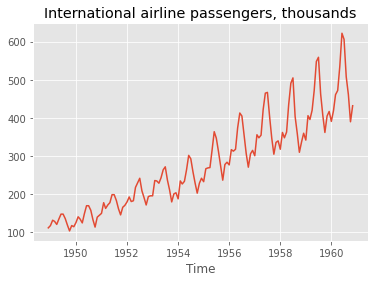

In [10]:
plt.plot(data.index.to_timestamp(), data['Passengers'])
plt.xlabel('Time')
plt.title('International airline passengers, thousands');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


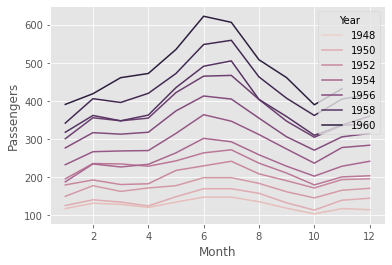

In [11]:
# Нарезка ряда на годы
data['Month'] = data.index.month
data['Year'] = data.index.year
sns.lineplot(data['Month'], data['Passengers'], hue=data['Year']);

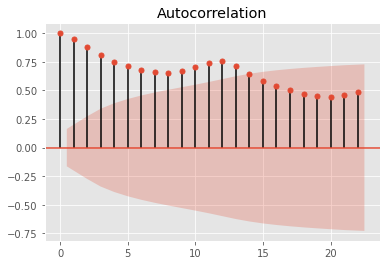

In [12]:
# Графики автокорреляционных функций
plot_acf(data['Passengers']);

##Твиттер

In [ ]:
# Ряды являются сезонными, имеют тренд - поэтому они не стационарны. Точек излома нет, амплитуда колебаний меняется, но не существенно.

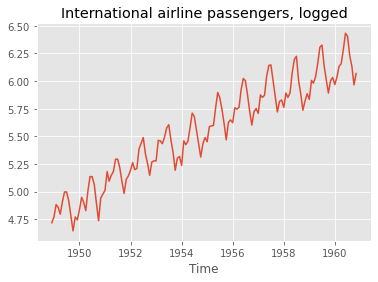

In [14]:
# Логарифм ряда
plt.plot(data.index.to_timestamp(), np.log(data['Passengers']))
plt.xlabel('Time')
plt.title('International airline passengers, logged');

#Двенадцать месяцев

##Наивная

In [15]:
mae = MeanAbsoluteError()
models = {}

In [16]:
data_train.columns=['Passengers']

In [17]:
models = dict()

Naive = NaiveForecaster(strategy='last')
Forecast = ForecastingHorizon(data_test.index, is_relative=False)
Naive.fit(data_train['Passengers'])
y_pred = Naive.predict(Forecast)

In [18]:
models['Naive forecaster'] = sklearn.metrics.mean_absolute_error(data_test, y_pred)

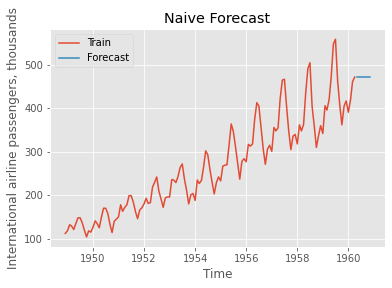

In [19]:
plt.plot(data_train.index.to_timestamp(), data_train['Passengers'], label='Train')
plt.plot(y_pred.to_timestamp().index, y_pred, label='Forecast')
plt.xlabel('Time')
plt.ylabel('International airline passengers, thousands')
plt.title('Naive Forecast')
plt.legend();

In [20]:
snaive = NaiveForecaster(strategy='last', sp=12)
snaive.fit(data_train['Passengers'])
y_pred = snaive.predict(Forecast)

models['Seasonal naive forecaster'] = sklearn.metrics.mean_absolute_error(data_test, y_pred)

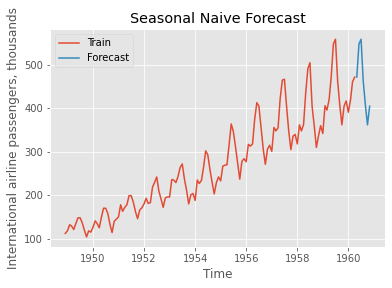

In [21]:
plt.plot(data_train.index.to_timestamp(), data_train['Passengers'], label='Train')
plt.plot(y_pred.to_timestamp().index, y_pred, label='Forecast')
plt.xlabel('Time')
plt.ylabel('International airline passengers, thousands')
plt.title('Seasonal Naive Forecast')
plt.legend();

##SARIMA

In [22]:
sarima = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
sarima.fit(data_train['Passengers'])
y_pred = sarima.predict(Forecast)

models['SARIMA'] = sklearn.metrics.mean_absolute_error(data_test, y_pred)

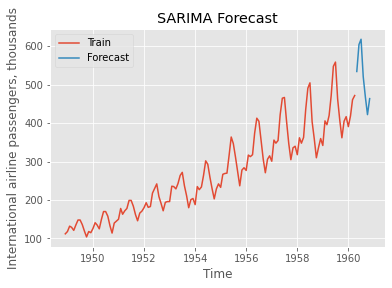

In [23]:
plt.plot(data_train.index.to_timestamp(), data_train['Passengers'], label='Train')
plt.plot(y_pred.to_timestamp().index, y_pred, label='Forecast')
plt.xlabel('Time')
plt.ylabel('International airline passengers, thousands')
plt.title('SARIMA Forecast')
plt.legend();

In [24]:
hyndman_khandakar = AutoARIMA(sp=12)
hyndman_khandakar.fit(data_train['Passengers'])
y_pred = hyndman_khandakar.predict(Forecast)

models['Hyndman Khandakar SARIMA'] = sklearn.metrics.mean_absolute_error(data_test, y_pred)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using z

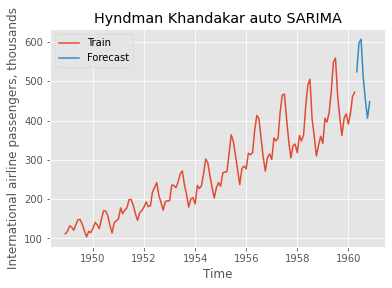

In [28]:
plt.plot(data_train.index.to_timestamp(), data_train['Passengers'], label='Train')
plt.plot(y_pred.to_timestamp().index, y_pred, label='Forecast')
plt.xlabel('Time')
plt.ylabel('International airline passengers, thousands')
plt.title('Hyndman Khandakar auto SARIMA')
plt.legend();

##ETS

In [41]:
ETS = AutoETS(error='add', trend='add', seasonal='add', sp=12)
data_train['Passengers'] = data_train['Passengers'].astype('float64')
ETS.fit(data_train['Passengers'])
y_pred = ETS.predict(Forecast)

models['ETS(AAA)'] = sklearn.metrics.mean_absolute_error(data_test, y_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


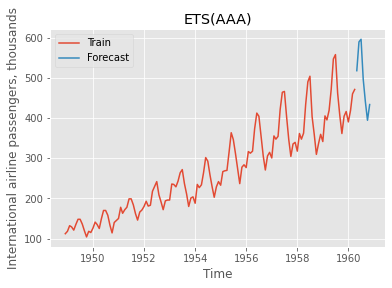

In [42]:
plt.plot(data_train.index.to_timestamp(), data_train['Passengers'], label='Train')
plt.plot(y_pred.to_timestamp().index, y_pred, label='Forecast')
plt.xlabel('Time')
plt.ylabel('International airline passengers, thousands')
plt.title('ETS(AAA)')
plt.legend();

In [43]:
ETS_AIC = AutoETS(auto=True, sp=12, allow_multiplicative_trend=True)
ETS_AIC.fit(data_train['Passengers'])
y_pred = ETS_AIC.predict(Forecast)

models['ETS_AIC'] = sklearn.metrics.mean_absolute_error(data_test, y_pred)

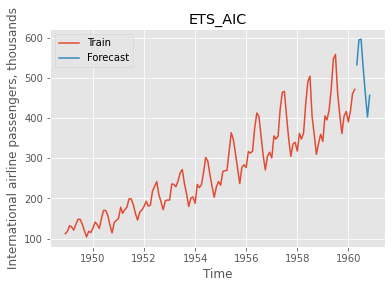

In [45]:
plt.plot(data_train.index.to_timestamp(), data_train['Passengers'], label='Train')
plt.plot(y_pred.to_timestamp().index, y_pred, label='Forecast')
plt.xlabel('Time')
plt.ylabel('International airline passengers, thousands')
plt.title('ETS_AIC')
plt.legend();

##Результаты

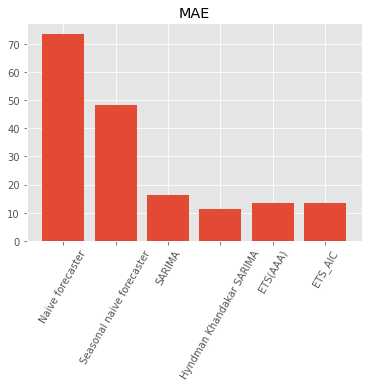

In [59]:
models_name_list, mae_list = list(zip(*models.items()))
plt.bar(models_name_list, mae_list)
plt.xticks(rotation=60)
plt.title('MAE');

Hyndman Khandakar Auto SARIMA оказалась лучшей моделью. Спрогнозируем следующий год с её помощью:

In [47]:
hyndman_khandakar.fit(data_train['Passengers'])
fh_new = ForecastingHorizon(np.arange(1, 13))

y_pred = hyndman_khandakar.predict(fh_new)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using z

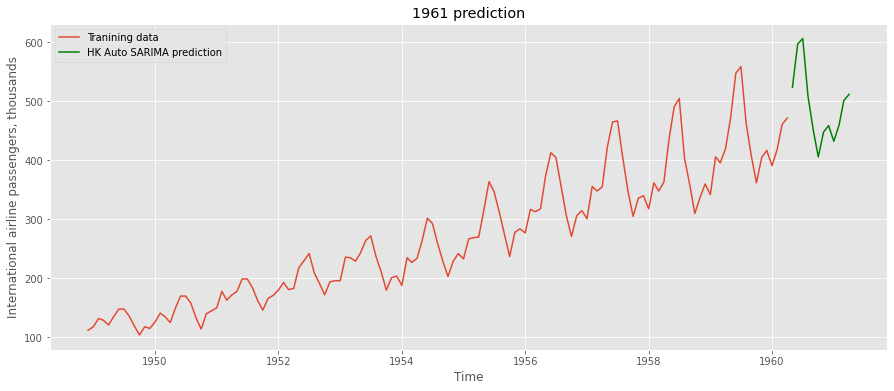

In [54]:
plt.figure(figsize=(15, 6))
plt.plot(data_train.index.to_timestamp(), data_train['Passengers'], label='Tranining data')
plt.plot(y_pred.to_timestamp().index, y_pred, label='HK Auto SARIMA prediction', c='g')
plt.xlabel('Time')
plt.ylabel('International airline passengers, thousands')
plt.title('1961 prediction')
plt.legend()
plt.show()

# Задания 6 — 10 (панельные данные)

In [64]:
!pip install linearmodels

     |████████████████████████████████| 1.5MB 3.8MB/s 


In [77]:
from linearmodels.panel.model import PanelOLS, RandomEffects, PooledOLS
from linearmodels.panel import compare
import statsmodels.api as sm

Заружаем и чистим данные, преобразовываем в формат, подходящий для linearmodels:

In [66]:
from google.colab import files
uploaded = files.upload()

Saving panelle.csv to panelle.csv


In [70]:
def str_to_num(x):
    try:
        return int(x)
    except:
        return np.nan

df = pd.read_csv('panelle.csv', encoding='utf-8')

df['J6_2'] = df['J6_2'].apply(str_to_num)
df['J13_2'] = df['J13_2'].apply(str_to_num)
df['log_wage'] = np.log(df['J13_2'] + 1)
df['work_hours'] = df['J6_2']
df = df.drop(['J6_2', 'J13_2'], axis=1)
df = df.dropna()

year = pd.Categorical(df.year)
df = df.set_index(["idind", "year"])
df["year"] = year
exog = sm.add_constant(df['work_hours'])
print(df.head())

            log_wage  work_hours  year
idind year                            
1     1998  5.686975        30.0  1998
2     1998  7.313887        40.0  1998
3     1998  6.857514        48.0  1998
7     1998  4.983607        25.0  1998
8     1998  7.090910        36.0  1998


Вопрос, который мы рассматриваем: "Зависит ли зарплата работника в России от количества часов работы в неделю?"

Построим скеттерплот, показывающий зависимость рассматриваемых переменных в разные годы:

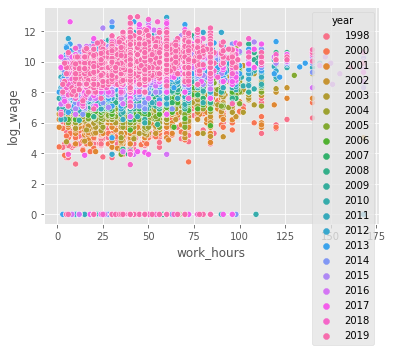

In [71]:
sns.scatterplot(data=df, x="work_hours", y="log_wage", hue=df['year'])
plt.show()

Рассмотрим различные модели:


## Fixed Effects

In [72]:
mod_fe = PanelOLS(df.log_wage, exog, entity_effects=True)
fe_res = mod_fe.fit()
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:               log_wage   R-squared:                        0.0018
Estimator:                   PanelOLS   R-squared (Between):              0.0081
No. Observations:              124025   R-squared (Within):               0.0018
Date:                Wed, Jun 16 2021   R-squared (Overall):              0.0069
Time:                        13:11:53   Log-likelihood                -1.796e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      177.74
Entities:                       25990   P-value                           0.0000
Avg Obs:                       4.7720   Distribution:                 F(1,98034)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             177.74
                            

## Random Effects

In [73]:
mod_re = RandomEffects(df['log_wage'], exog)
re_res = mod_re.fit()
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:               log_wage   R-squared:                        0.4984
Estimator:              RandomEffects   R-squared (Between):              0.0124
No. Observations:              124025   R-squared (Within):               0.0015
Date:                Wed, Jun 16 2021   R-squared (Overall):              0.0083
Time:                        13:12:17   Log-likelihood                -1.935e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.232e+05
Entities:                       25990   P-value                           0.0000
Avg Obs:                       4.7720   Distribution:                F(1,124023)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             480.27
                            

## Pooled OLS

In [74]:
mod_pols = PooledOLS(df['log_wage'], exog)
pols_res = mod_pols.fit()
print(pols_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:               log_wage   R-squared:                        0.0099
Estimator:                  PooledOLS   R-squared (Between):              0.0143
No. Observations:              124025   R-squared (Within):              -0.0008
Date:                Wed, Jun 16 2021   R-squared (Overall):              0.0099
Time:                        13:12:43   Log-likelihood                 -2.25e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1236.8
Entities:                       25990   P-value                           0.0000
Avg Obs:                       4.7720   Distribution:                F(1,124023)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             1236.8
                            

## Сравним модели

Используем F-test для сравнения Pooled OLS и Fixed Effects, и тест Хаусмана для сравнения Fixed Effects и Random Effects.

## Pooled OLS vs. Fixed Effects

In [78]:
print(compare({'Pooled OLS': pols_res, 'FE': fe_res}))

                   Model Comparison                  
                            Pooled OLS             FE
-----------------------------------------------------
Dep. Variable                 log_wage       log_wage
Estimator                    PooledOLS       PanelOLS
No. Observations                124025         124025
Cov. Est.                   Unadjusted     Unadjusted
R-squared                       0.0099         0.0018
R-Squared (Within)             -0.0008         0.0018
R-Squared (Between)             0.0143         0.0081
R-Squared (Overall)             0.0099         0.0069
F-statistic                     1236.8         177.74
P-value (F-stat)                0.0000         0.0000
=====================     ============   ============
const                           8.5100         8.7976
                              (545.31)       (479.11)
work_hours                      0.0122         0.0056
                              (35.168)       (13.332)
======================= ====

Нулевая гипотеза состоит в том, что entity effects незначительны, и в таком случае лучше будет Pooled OLS; иначе побеждает модель Fixed Effects. Как видно из таблицы сверху, p-value = 0, следовательно нулевая гипотеза отвергается.

### Fixed Effects > Pooled OLS

## Fixed Effects vs. Random Effects

Используем функцию, проводящую тест Хаусмана, взятую отсюда: https://github.com/sglyon/econtools/blob/master/Python/econtools/metrics.py

In [79]:
import numpy.linalg as la
from scipy import stats

def hausman(fe, re):
    """
    Compute hausman test for fixed effects/random effects models
    b = beta_fe
    B = beta_re
    From theory we have that b is always consistent, but B is consistent
    under the alternative hypothesis and efficient under the null.
    The test statistic is computed as
    z = (b - B)' [V_b - v_B^{-1}](b - B)
    The statistic is distributed z \sim \chi^2(k), where k is the number
    of regressors in the model.
    Parameters
    ==========
    fe : statsmodels.regression.linear_panel.PanelLMWithinResults
        The results obtained by using sm.PanelLM with the
        method='within' option.
    re : statsmodels.regression.linear_panel.PanelLMRandomResults
        The results obtained by using sm.PanelLM with the
        method='swar' option.
    Returns
    =======
    chi2 : float
        The test statistic
    df : int
        The number of degrees of freedom for the distribution of the
        test statistic
    pval : float
        The p-value associated with the null hypothesis
    Notes
    =====
    The null hypothesis supports the claim that the random effects
    estimator is "better". If we reject this hypothesis it is the same
    as saying we should be using fixed effects because there are
    systematic differences in the coefficients.
    """

    # Pull data out
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov

    # NOTE: find df. fe should toss time-invariant variables, but it
    #       doesn't. It does return garbage so we use that to filter
    data = b[np.abs(b) < 1e8].size

    # compute test statistic and associated p-value
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B))
    pval = stats.chi2.sf(chi2, data)

    return chi2, data, pval

In [80]:
if hausman(fe_res, re_res)[2] < 0.01:
    print('Нулевая гипотеза отвергается на 1% уровне значимости')
else:
    print('Нулевая гипотеза не отвергается на 1% уровне значимости')

Нулевая гипотеза отвергается на 1% уровне значимости


Так как нулевая гипотеза теста Хаусмана отвергается на 1% уровне значимости, можно сказать, что оценка моделью Random Effects не состоятельна. Следовательно, модель Fixed Effects побеждает.

### Fixed Effects > Random Effects

### Для рассмотренных данных модель Fixed Effects побеждает остальные модели.

## Ответ на главный вопрос

Как мы увидели ранее, модель Fixed Effects побеждает остальные модели. Судя по её оценке, количество часов работы в неделю действительно влияет на заработную плату — в среднем каждый дополнительный час работы в неделю увеличивает заработную плату на 0.56%. Кроме того, p-value = 0, следовательно коэффициент значим.